In [1]:
from metrics import *
import numpy as np
import matplotlib.pyplot as plt

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [5]:
import torch

In [3]:
image = np.ones((25, 25))

noise = np.random.normal(loc=0, scale=0.1, size=(25, 25))  # Gaussian noise with mean 0 and standard deviation 0.1
image_reconstructed_w_noise = {'mean': np.clip(image + noise, 0, 1),
                               'var': noise}

num_elems = image.size
perc = 1/num_elems
y = [perc * i  for i in range(num_elems)]
  
input_instance = image
mean_result = image_reconstructed_w_noise['mean']
var_result = image_reconstructed_w_noise['var']
        
# Compute sparsification curves for the predicted depth map
def sparsification(error, uncertainty):
    x, y = np.unravel_index(np.argsort(uncertainty, axis=None)[::-1], uncertainty.shape) # Descending order
    return np.array([error[x][y] for x, y in zip(x, y)])

error = np.abs(input_instance - mean_result) # RMSE -> ABS

sparsification_prediction = sparsification(error, var_result)
sparsification_oracle = sparsification(error, error)

# Compute the means of the sparsification curves
sparsification_errors_means = []
sparsification_oracle_means = []
sum_errors_means = np.sum(sparsification_prediction)
sum_oracle_means = np.sum(sparsification_oracle)
for i in range(num_elems):
    sparsification_errors_means.append(sum_errors_means / (num_elems - i))
    sparsification_oracle_means.append(sum_oracle_means / (num_elems - i))
    sum_errors_means -= sparsification_prediction[i]
    sum_oracle_means -= sparsification_oracle[i]

# Compute the AUSE by integrating the absolute values of the error differences
## Normalization of the sparsification curves
sparsification_errors_means_normalized = (sparsification_errors_means - np.min(sparsification_errors_means)) / (np.max(sparsification_errors_means) - np.min(sparsification_errors_means))
sparsification_oracle_means_normalized = (sparsification_oracle_means - np.min(sparsification_oracle_means)) / (np.max(sparsification_oracle_means) - np.min(sparsification_oracle_means))
sparsification_errors = np.abs(np.array(sparsification_oracle_means_normalized) - \
                                np.array(sparsification_errors_means_normalized))
ause = np.trapz(sparsification_errors, y)
    


0.36785328795029826


Text(0.5, 1.0, 'Prediction and oracle sparsification curves')

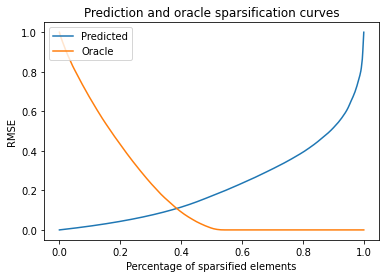

In [7]:
# Plot the data
plt.plot(y, sparsification_errors_means_normalized, label='Predicted')
plt.plot(y, sparsification_oracle_means_normalized, label='Oracle')
plt.legend(loc="upper left")

plt.xlabel('Percentage of sparsified elements')
plt.ylabel('RMSE')
plt.title('Prediction and oracle sparsification curves')

In [ ]:
def compute_ause(input_batch, result_batch):
    """Compute the Area Under the Sparsification Error (AUSE)."""
    input_batch = input_batch.cpu().numpy()
    result_batch = {k: v.cpu().numpy() for k, v in result_batch.items()}
    
    auses = []

    num_elems = input_batch[0][0].size
    perc = 1/num_elems
    y = [perc * i  for i in range(num_elems)]
    for instance_id in range(input_batch.shape[0]):
        input_instance = input_batch[instance_id][0]
        mean_result = result_batch['mean'][instance_id][0]
        var_result = result_batch['var'][instance_id][0]
        # Compute sparsification curves for the predicted depth map
        def sparsification(error, uncertainty):
            x, y = np.unravel_index(np.argsort(uncertainty, axis=None)[::-1], uncertainty.shape) # Descending order
            return np.array([error[x][y] for x, y in zip(x, y)])
        error = np.abs(input_instance - mean_result) # RMSE -> ABS
        sparsification_prediction = sparsification(error, var_result)
        sparsification_oracle = sparsification(error, error)
        # Compute the means of the sparsification curves
        sparsification_errors_means = []
        sparsification_oracle_means = []
        sum_errors_means = np.sum(sparsification_prediction)
        sum_oracle_means = np.sum(sparsification_oracle)
        for i in range(num_elems):
            sparsification_errors_means.append(sum_errors_means / (num_elems - i))
            sparsification_oracle_means.append(sum_oracle_means / (num_elems - i))
            sum_errors_means -= sparsification_prediction[i]
            sum_oracle_means -= sparsification_oracle[i]
        # Compute the AUSE by integrating the absolute values of the error differences
        ## Normalization of the sparsification curves
        sparsification_errors_means_normalized = (sum_errors_means - np.min(sum_errors_means)) / \
                                                 (np.max(sum_errors_means) - np.min(sum_errors_means))
        sparsification_oracle_means_normalized = (sum_oracle_means - np.min(sum_oracle_means)) / \
                                                 (np.max(sum_oracle_means) - np.min(sum_oracle_means))
        sparsification_errors = np.abs(np.array(sparsification_oracle_means_normalized) - \
                                       np.array(sparsification_errors_means_normalized))
        auses.append(np.trapz(sparsification_errors, y))

    return np.array(auses).mean()